# Example of usage

In [1]:
#Autoreload .py files
%load_ext autoreload
%autoreload 2

#https://github.com/chmp/ipytest/issues/80
import sys
sys.breakpointhook = sys.__breakpointhook__

Load required libraries

In [2]:
import xarray as xr
import numpy as np
from pathlib import Path
from xarrayvideo import xarray2video, video2xarray, gap_fill, plot_image, to_netcdf
import matplotlib.pyplot as plt

Set up some variables and load an example minicube

In [3]:
array_id= '-111.49_38.60'
input_path= '../mc_-111.49_38.60_1.2.2_20230702_0.zarr'
output_path= './out'
use_B07= True

In [4]:
minicube= xr.open_dataset(input_path, engine='zarr')
minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
minicube['cloudmask_en']= minicube['cloudmask_en'].astype(np.uint8)
if not use_B07: minicube= minicube.drop_vars('B07') #We drop a variable for now

In [5]:
minicube

<xarray.Dataset>
Dimensions:       (time: 495, y: 128, x: 128, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 2016-01-03T12:00:00 ... 2022-10-08T12...
  * x             (x) float64 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 9.785e+05 9.788e+05 ... 9.806e+05 9.809e+05
  * y             (y) float64 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 4.288e+06 4.287e+06 ... 4.286e+06 4.285e+06
Data variables: (12/38)
    B02           (time, y, x) float32 ...
    B03           (time, y, x) float32 ...
    B04           (time, y, x) float32 ...
    B05           (time, y, x) float32 ...
    B06           (time, y, x) float32 ...
    B07           (time, y, x) float32 ...
    ...            ...
    t2m_max       (time) float32 ...
    t2m_mean      (time) float32 ...
    t2m_min       (time) float32 ...
    tp_max        (time) float32 ...
    tp_mean       (time) float32 ...
    tp_min        (time) float32 ...
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

Fix the small jitter betweeen timesteps to improve compression

In [6]:
import satalign

#Reload minicube for testing
minicube= xr.open_dataset(input_path, engine='zarr')
minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
if not use_B07: minicube= minicube.drop_vars('B07') #We drop a variable for now

bands= ['B04','B03','B02','B8A','B06','B05'] + (['B07'] if use_B07 else [])
reference_image= minicube[bands].isel(time=slice(74,None)).mean("time").to_array().transpose('variable', 'y', 'x')
datacube= minicube[bands].to_array().transpose('time', 'variable', 'y', 'x')

syncmodel= satalign.PCC( #PCC quicker, ECC more precise
    datacube=datacube, # T x C x H x W
    reference=reference_image, # C x H x W
    channel="mean", crop_center=96, num_threads=1)
new_cube, warps= syncmodel.run_multicore()

/home/oscar/.conda/envs/pt2/lib/python3.10/site-packages/satalign/pcc.py:78: UserWarning: Could not determine RMS error between images with the normalized average intensities 9214516.0 and 0.0. Either the reference or moving image may be empty.
  shift, error, diffphase = phase_cross_correlation(
/home/oscar/.conda/envs/pt2/lib/python3.10/site-packages/satalign/main.py:227: UserWarning: Estimated translation is too large
  warnings.warn("Estimated translation is too large")


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

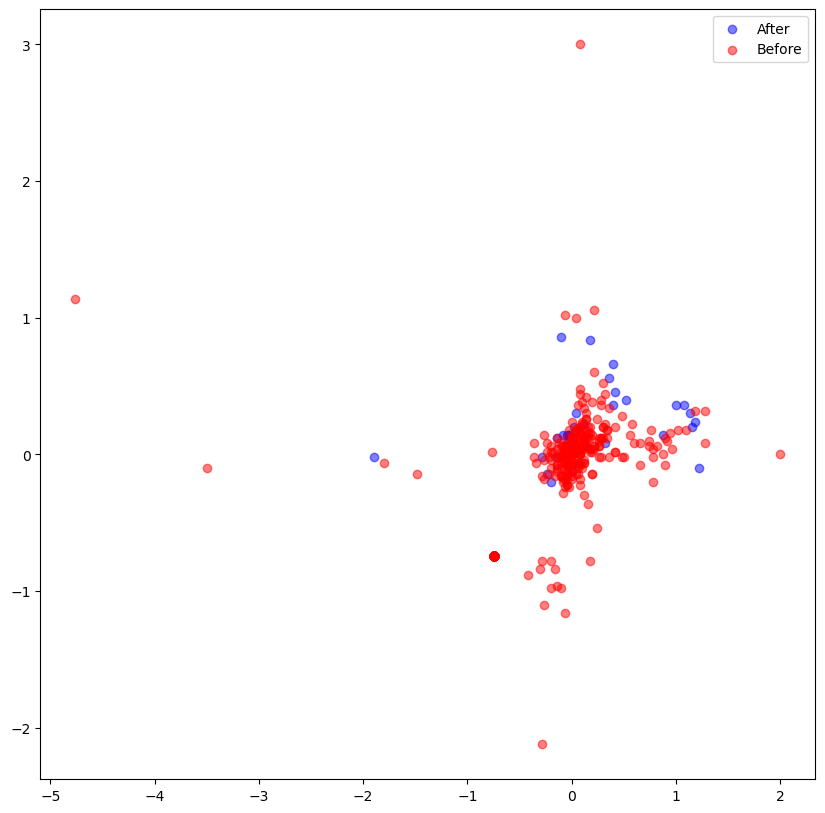

In [7]:
#Plot scatter plot
warp_df = satalign.utils.warp2df(warps, datacube.time.values)
satalign.utils.plot_s2_scatter(warp_df)

In [8]:
#Copy back
for b in bands:
    minicube[b]= new_cube.sel(variable=b)

Gap-fill in clouds

For now, we won't apply gap-filling of the clouds, since it is too big of a change to the data. If a good gap-filling algorithm were to be used, we could save up much more space when converting to video

In [9]:
#Perform the gap filling. Three methods: last_value, interp_forward, interp (non-causal!!)
minicube_filled= gap_fill(minicube, fill_bands=bands, mask_band='cloudmask_en',
                          fill_values=[1, 3, 4], method='last_value', new_mask='invalid', 
                          coord_names=('time', 'variable', 'y', 'x'))

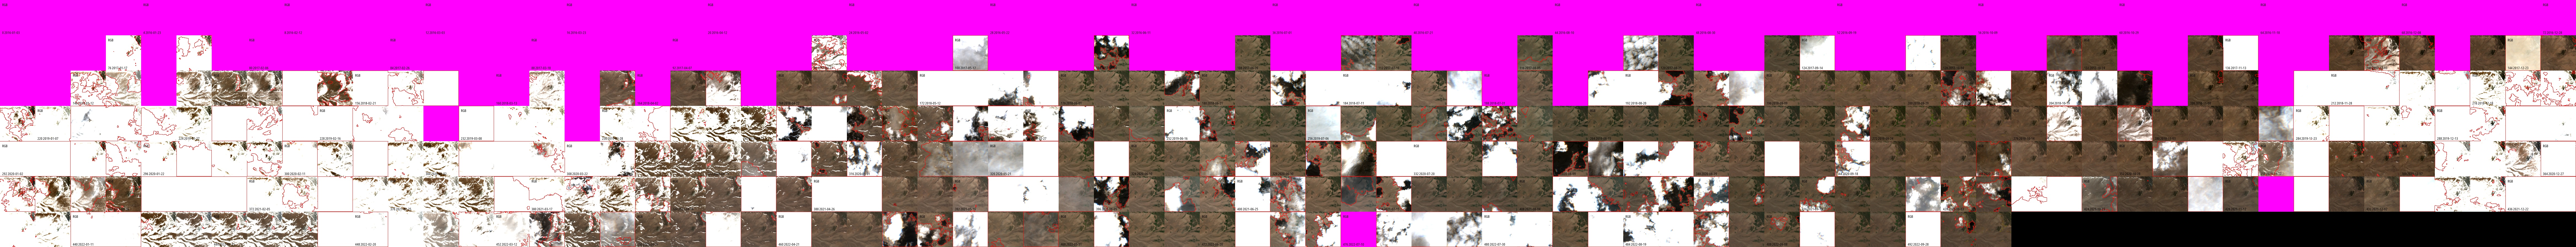

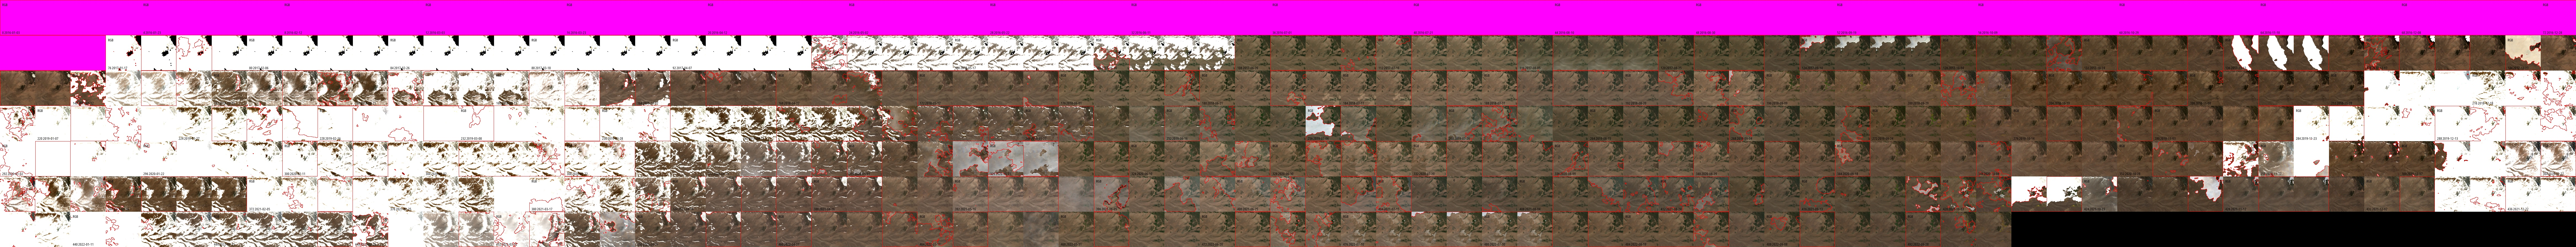

In [10]:
#RGB orig
plot_image(minicube, ['B04','B03','B02'], mask_name='cloudmask_en', save_name='./out/RGB original.jpg')

#RGB gap-filled
plot_image(minicube_filled, ['B04','B03','B02'], mask_name='invalid', save_name='./out/RGB gap-filled.jpg')

In [11]:
minicube

<xarray.Dataset>
Dimensions:       (time: 495, y: 128, x: 128, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 2016-01-03T12:00:00 ... 2022-10-08T12...
  * x             (x) float64 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 9.785e+05 9.788e+05 ... 9.806e+05 9.809e+05
  * y             (y) float64 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 4.288e+06 4.287e+06 ... 4.286e+06 4.285e+06
    variable      <U3 'B04'
Data variables: (12/38)
    B02           (time, y, x) float32 0.0 0.0 0.0 ... 0.06185 0.06106 0.06242
    B03           (time, y, x) float32 0.0 0.0 0.0 ... 0.08014 0.07839 0.0823
    B04           (time, y, x) float32 0.0 0.0 0.0 ... 0.09636 0.09845 0.1036
    B05           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1155 0.1171 0.1222
    B06           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1332 0.1409 0.1453
    B07           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1452 0.1531 0.1551
    ...            ...
    t2m_max       (time) float32 ...
    t2m_mean      (time) float32 ...
    t2m_min       (time) float32 ...
    tp_max        (time) float32 ...
    tp_mean       (time) float32 ...
    tp_min        (time) float32 ...
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

Since we are basically using `ffmpeg` for the enconding, here are some important commands

In [12]:
#Get info of a particular encoder
!ffmpeg -h encoder=libx265 -v quiet #vp9, libx264, libx265, ffv1, prores_ks, dnxhd

Encoder libx265 [libx265 H.265 / HEVC]:
    General capabilities: dr1 delay threads 
    Threading capabilities: other
    Supported pixel formats: yuv420p yuvj420p yuv422p yuvj422p yuv444p yuvj444p gbrp yuv420p10le yuv422p10le yuv444p10le gbrp10le yuv420p12le yuv422p12le yuv444p12le gbrp12le gray gray10le gray12le
libx265 AVOptions:
  -crf               <float>      E..V....... set the x265 crf (from -1 to FLT_MAX) (default -1)
  -qp                <int>        E..V....... set the x265 qp (from -1 to INT_MAX) (default -1)
  -forced-idr        <boolean>    E..V....... if forcing keyframes, force them as IDR frames (default false)
  -preset            <string>     E..V....... set the x265 preset
  -tune              <string>     E..V....... set the x265 tune parameter
  -profile           <string>     E..V....... set the x265 profile
  -udu_sei           <boolean>    E..V....... Use user data unregistered SEI if available (default false)
  -x265-params       <dictionary> E..V....... set

Compress and write new file

If you get `ContainsGroupError`, make sure to delete the existing `out` folder:

In [13]:
#Remove out folder to avoid errors
!rm -rf ./out

Define conversion rules for the different bands. The syntax is:
```
'video_name': ( 
    var or (var1, var2, var3), #Variables present in the xarray
    (t_coord_name, x_coord_name, y_coord_name), #Names of the coordinates in order (t, x, y)
    [Optional] n_components: 0 or n_components 
        - 0: store all bands in sets of 3 channels, last video might only have 1 or 2 channels (less efficient)
        - n_components: store all bands using n_components, which must be divisable by 3
    [Optional] compression parameters dictionary:  
       {
        'c:v': 'libx264',  #[libx264, libx265, vp9, ffv1]
        'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
        'crf': 3, #3 default, the lower, the higher the quality
       },
    [Optional] number of bits (e.g.: 8,10,12,16),
...
```

In [14]:
#Save original minicube for comparing the size (it will be compressed)
Path(output_path).mkdir(exist_ok=True, parents=True)
#minicube.to_zarr(Path(output_path) / f'{array_id}.zarr')
to_netcdf(minicube, Path(output_path) / f'{array_id}.nc')

In [15]:
#Define the output video encoding parameters

#Lossless
#Best for lossless 1-channel: ffv1
lossless_params= {'c:v':'ffv1'}

#Best for lossless 3-channel: vp9
# lossless_params= {'c:v':'vp9', 'lossless':1, 'deadline':'good'} #good, best, realtime

#Lossy 
#Best for lossy 3-channel: libx264, 10 bits / libx265, 12 bits
#Psychovisual Rate-Distortion Optimization (Psy-RD) is a technique used in video encoding 
#that adjusts the bit allocation and quantization to improve the perceived visual quality 
#of the encoded video. This method takes into account the human visual system's sensitivity 
#to different types of distortions and allocates more bits to areas that are more noticeable 
#to the human eye, such as edges and textures, while compressing other areas more aggressively.
lossy_params = {
    'c:v': 'libx265',  #[libx264, libx265, vp9, ffv1]
    'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': [0], #14 default, 11 for higher quality and size
    # 'tune': 'ssim', #ssim, psnr
    # 'x265-params': 'no-sao:selective-sao=0',
    'x265-params': 'qpmin=0:qpmax=5:psy-rd=0:psy-rdoq=0', #Usually with crf=0 this is around 4-8, sot set higher to go <0
    # "lookahead-slices=1"
    #psy-rd=0:psy-rdoq=0
    }

#Define conversion rules for the different bands
#We can manually choose how to compress the different bands
conversion_rules= {    
#     #Sets of 3 channels are the most efficient for lossy compression
    'rgb': ( ('B04','B03','B02'), ('time','x','y'), 0, lossy_params, 10), #[0, 0.4]
    'ir3': ( ('B8A','B06','B05'), ('time','x','y'), 0, lossy_params, 10),
    
#     #Compressing 1 channel lossy is not efficient, as just repeats the channel 3 times
#     'r': ( 'B04', ('time','x','y'), 0, lossy_params, 10),
    
#     #Compressing 1,3, or 4 channels losslessly is efficient, as a different codec
#     #supporting those configurations can be used
#     'cm': ( 'cloudmask_en', ('time','x','y'), 0, lossless_params, 8),
#     'scl': ( 'SCL', ('time','x','y'), 0, lossless_params, 8),
    }

#There are also automatic modes for encoding many bands at once
# conversion_rules= {
    #We can do PCA and keep a subset of principal components (e.g. 6)
    # 'all': ( ('B07', 'B06','B05','B04','B03','B02','B8A'), ('time','x','y'), 7, lossy_params, 10),
    
    #We can pass all the bands, NOT do PCA, and repeat any bands if needed so that they are divisible by 3
    # 'all2': ( ('B07', 'B06','B05','B04','B03','B02','B8A'), ('time','x','y'), 0, lossy_params, 10),
    # }

In [16]:
#TODO (not working): SSIM new impl., read cubes that were saved as sets of 3 channels

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

rgb: 92.81Mb -> ['3.58']Mb (3.85% of original size, 1.2326 bpppb) in 9.78s
 - params={'c:v': 'libx265', 'preset': 'medium', 'crf': [0], 'x265-params': 'qpmin=0:qpmax=5:psy-rd=0:psy-rdoq=0'}
 - Decompression time 0.31s


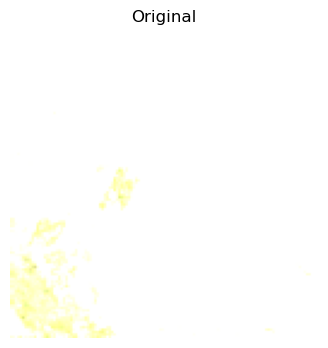

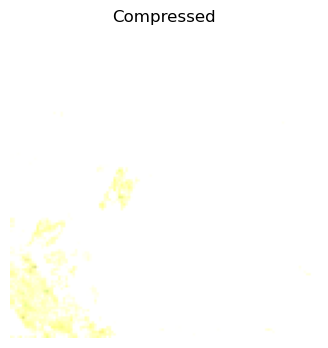

Saturation values per band ('B04', 'B03', 'B02')):
 [[0.  0.4]
 [0.  0.4]
 [0.  0.4]]
 - MSE_sat 0.051078 (input saturated)
 - SNR_sat 5.6061 (input saturated)
 - PSNR_sat 4.9589 (input saturated)
 - Exp. SA 0.0144 (input saturated)


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

ir3: 92.81Mb -> ['2.75']Mb (2.96% of original size, 0.9487 bpppb) in 9.14s
 - params={'c:v': 'libx265', 'preset': 'medium', 'crf': [0], 'x265-params': 'qpmin=0:qpmax=5:psy-rd=0:psy-rdoq=0'}
 - Decompression time 0.27s


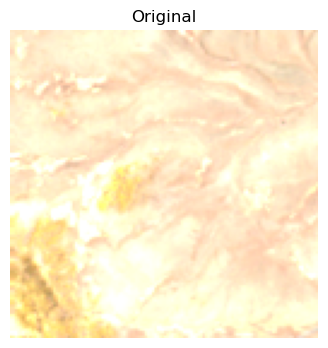

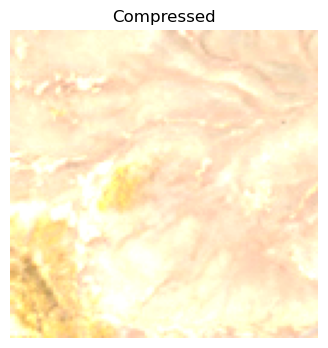

Saturation values per band ('B8A', 'B06', 'B05')):
 [[8.779687e-03 1.555900e+00]
 [1.000000e-04 1.578800e+00]
 [0.000000e+00 1.589600e+00]]
 - MSE_sat 0.000016 (input saturated)
 - SNR_sat 40.6513 (input saturated)
 - PSNR_sat 51.9394 (input saturated)
 - Exp. SA 0.0081 (input saturated)


In [18]:
#Run with compute_stats (takes a bit longer). Activating `use_ssim` takes even longer
arr_dict= xarray2video(minicube, array_id, conversion_rules, fmt='mkv',
                       output_path=output_path, use_ssim=False, compute_stats=True,
                       loglevel='verbose', #verbose, quiet
                       save_dataset= False
                       )  

In [ ]:
#Get info of an encoded video
#!ffprobe -v error -show_format -show_streams out/-111.49_38.60/ir4.mkv

Compute total size, and observe a signficant compression rate (~20x)

In [ ]:
original_path= str(Path(output_path) / f'{array_id}.nc')
!du -h {original_path} -d0

In [ ]:
new_path= str(Path(output_path) / f'{array_id}')
!du -h {new_path} 

Read again the written file, and check that everything has persisted

In [ ]:
minicube_new= video2xarray(output_path, array_id, fmt='mkv') 
minicube_new

Visualize results

In [ ]:
#RGB
plot_image(minicube, ['B04','B03','B02'], save_name='./out/RGB original.jpg')
plot_image(minicube_new, ['B04','B03','B02'], save_name='./out/RGB compressed.jpg')

In [ ]:
#R3
plot_image(minicube, ['B8A','B06','B05'], save_name='R3 original.jpg')
plot_image(minicube_new, ['B8A','B06','B05'], save_name='R3 compressed.jpg')

In [ ]:
#Gray
# plot_image(minicube, ['B07'], plot_idx=[[0]], save_name='Gray Compressed.jpg')
# plot_image(minicube_new, ['B07'], plot_idx=[[0]], save_name='Gray Compressed.jpg')

In [ ]:
#RGBA
# plot_image(minicube, ['B8A','B07','B06','B05'], plot_idx=[[0],[1],[2],[3]], save_name='RGBA Compressed.jpg')
# plot_image(minicube_new, ['B8A','B07','B06','B05'], plot_idx=[[0],[1],[2],[3]], save_name='RGBA Compressed.jpg')
# txy_real_rgba_compressed= np.transpose(arr_dict['ir4'][0], (3,0,1,2)) #t,x,y,3 -> 4,t,x,y

Watch as a video (some formats might not be supported)

In [ ]:
from IPython.display import Video, display, HTML, Image
for video in conversion_rules.keys():
    path= Path(output_path) / array_id / f'{video}.mkv'
    display(HTML(f'<h4>{video}</h4>{path}'))
    # display(HTML(f"""
    # <video width="512" height="512" controls>
    #   <source src="{path}">
    # </video>
    # """))
    display(Video(path, width=512, height=512, embed=True))

## Use for climate data

In [ ]:
# era5_version= '1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr' #623Tb
era5_version= '1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr' #80Tb
# era5_version= '1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr' #2Tb
# era5_version= '1959-2023_01_10-6h-64x32_equiangular_conservative.zarr' #163Gb

In [ ]:
era5= xr.open_zarr(f'gs://weatherbench2/datasets/era5/{era5_version}') 
print(f'Size: {era5.nbytes / 2**30:.3f}Gb')
era5

In [ ]:
#Choose a subset of the dataset
import pandas as pd
start= '2022-07-01'
data_from_start_date= era5.sel(time=slice(pd.Timestamp(start), None))

#Save
#data_from_start_date.to_zarr(f'since_{start}_{era5_version}')

In [ ]:
import pandas as pd

#Open from local
era5_version= '../since_2022-07-01_1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr' #80Tb
era5_version= '../since_2022-07-01_2022-07-01_1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
# era5_version= '../1959-2023_01_10-6h-64x32_equiangular_conservative.zarr' #163Gb

era5= xr.open_dataset(era5_version, engine='zarr')
print(f'Size: {era5.nbytes / 2**30:.3f}Gb')
era5

In [ ]:
lossy_params = {
    'c:v': 'libx265',  #[libx264, libx265, vp9, ffv1]
    'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': [0],#,1,3,6,9], #14 default, 11 for higher quality and size
    'x265-params': 'qpmin=0:qpmax=0.001:psy-rd=0:psy-rdoq=0',
    }

conversion_rules= {
    # 'wind': ( ('10m_u_component_of_wind', '10m_v_component_of_wind', '10m_wind_speed'), ('time', 'longitude', 'latitude'), 
             # 0, lossy_params, 10),
    # 'wind_speed': ('wind_speed', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    # # 'wind_speed2': ('wind_speed', ('time', 'longitude', 'latitude', 'level'), 12, lossy_params, 10),
    'wind_speed': ('wind_speed', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    'wind_u': ('u_component_of_wind', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    }

arr_dict= xarray2video(era5.sel(time=slice(pd.Timestamp('2022-11-01'), None)), 
                       era5_version.replace('.zarr', ''), conversion_rules, fmt='mkv',
                       output_path=output_path, use_ssim=False, compute_stats=True,
                       loglevel='verbose', #verbose, quiet
                       save_dataset=False #Disable saving
                       )  

## Testing Cesar's cloudless data

In [ ]:
#Load data
data= np.load('../s2data.npy')
cesar_bands= ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

#Create the xarray.DataArray
xdata= xr.Dataset(
    {band: ( ['time', 'x', 'y'], data[:,bi] ) for bi,band in enumerate(cesar_bands)},
    coords={
        'time': pd.date_range("2015-09-01", periods=106, freq='M'),
        'x': np.arange(512),
        'y': np.arange(512),
    },
)

xdata= xdata.astype(np.float32) / 10000.
xdata

In [ ]:
lossy_params = {
    'c:v': 'libx265',  #[libx264, libx265, vp9, ffv1]
    'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': [2],#,1,3,6,9], #14 default, 11 for higher quality and size
    'x265-params': 'qpmin=0:qpmax=8:psy-rd=0:psy-rdoq=0',
    }

conversion_rules= {
    'rgb': (['B4', 'B3', 'B2'], ('time', 'x', 'y'), 0, lossy_params, 12),
    # 'all': (cesar_bands, ('time', 'x', 'y'), 0, lossy_params, 10),
    }

arr_dict= xarray2video(xdata, 'cesar', conversion_rules, fmt='mkv',
                       output_path=output_path, use_ssim=False, compute_stats=True,
                       loglevel='verbose', #verbose, quiet
                       save_dataset=False #Disable saving
                       )  

In [ ]:
new_path= str(Path(output_path) / 'cesar')
!du -h {new_path} 

Read again the written file, and check that everything has persisted

In [ ]:
xdata_new= video2xarray(output_path, 'cesar', fmt='mkv') 
xdata_new

Visualize results

In [ ]:
#RGB
plot_image(xdata, ['B4','B3','B2'], mask_name=None, stack_every=12, save_name='./out/RGB original.jpg')
plot_image(xdata_new, ['B4','B3','B2'], mask_name=None, stack_every=12, save_name='./out/RGB compressed.jpg')

## Plot some compression graphs for DeepExtremes

In [ ]:
raise None

In [ ]:
#Remove out folder to avoid errors
!rm -rf ./testing

In [ ]:
#assert False, 'Comment this cell to run. This takes a long time'

#Load libs
from tqdm.notebook import tqdm
import warnings
rng= np.random.default_rng(seed=42)

#Define crfs and tests
tests= ['libx264_slow_ffv1', 'libx265_medium_ffv1', 'vp9_quick_vp9']
#['libx264_slow_ffv1', 'libx265_medium_ffv1', 'vp9_quick_vp9']
#crfs= [-1, 0,1,2,4,7,11,16,22,29]
crfs= [-1,0,1,2,3,4,6,12,20,30]
n_bits= [8,10,12]
use_ssim= False

#Take N random cubes
dataset_in_path= Path('./') #Path('/scratch/users/deepextremes/deepextremes-minicubes/full')
cube_paths= np.array(list(dataset_in_path.glob('*.zarr'))) #'*/*.zarr'
rng.shuffle(cube_paths)
cube_paths= cube_paths[:10]

#Run
overall_results={}
for input_path in (pbar:=tqdm(cube_paths, total=len(cube_paths))):
    #Create cube id
    array_id= '_'.join(input_path.stem.split('_')[1:3])
    overall_results[array_id]= {}

    #Load
    minicube= xr.open_dataset(input_path, engine='zarr')
    minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
    minicube['cloudmask_en']= minicube['cloudmask_en'].astype(np.uint8)
    minicube= minicube.drop_vars('B07') #We drop a variable for now

    #Align
    bands= ['B04','B03','B02','B8A','B06','B05']
    minicube[bands]= minicube[bands].isel(time=slice(74*2,None)) #Frist two years have too much missing data
    reference_image= minicube[bands].mean("time").to_array().transpose('variable', 'y', 'x')
    datacube= minicube[bands].to_array().transpose('time', 'variable', 'y', 'x')
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore")
        syncmodel= satalign.PCC( #PCC quicker, ECC more precise
            datacube=datacube, # T x C x H x W
            reference=reference_image, # C x H x W
            channel="mean", crop_center=96, num_threads=1)
        new_cube, warps= syncmodel.run_multicore()
        for b in bands: minicube[b]= new_cube.sel(variable=b)

    for test in tests:
        overall_results[array_id][test]= {}
        for crf in crfs:
            overall_results[array_id][test][crf]= {}
            for bits in n_bits:
                #Update pbar
                pbar.set_description(f'{test=} | {array_id=} | {crf=} | {bits=}')

                #Set up parameters
                codec_lossy, preset, codec_lossless= test.split('_')
                lossless= {
                    'c:v': codec_lossless,
                    'preset': preset, 
                    'lossless': 1, #Only for vp9
                    } 
                lossy = {
                    'c:v': codec_lossy,  #[libx264, libx265, vp9, ffv1]
                    'preset': preset,  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
                    'crf': crf, #11 default, the lower the higher the quality
                    }
                if codec_lossless == 'vp9': #vp9 can do lossless compression
                    lossless_params= lossy_params

                conversion_rules= {
                    # 'r': ( 'B04', ('time','x','y'), 'lossy'), #1 channel + lossy not working
                    # 'ir4': ( ('B8A','B07','B06','B05'), ('time','x','y'), 'lossy'), #4 channels not working
                    'rgb': ( ('B04','B03','B02'), ('time','x','y'), False, lossy if crf>=0 else lossless, bits),
                    'ir3': ( ('B8A','B06','B05'), ('time','x','y'), False, lossy if crf>=0 else lossless, bits),
                    }

                try:
                    #Run with compute_stats (takes a bit longer). Activating `use_ssim` takes even longer
                    results= xarray2video(minicube, array_id, conversion_rules, fmt='mkv',
                                           output_path=Path('./testing/'), use_ssim=use_ssim, compute_stats=True,
                                           loglevel='quiet',#verbose, quiet
                                           verbose=False, 
                                           )
                    overall_results[array_id][test][crf][bits]= results
                    
                    #Delete files
                    for file in [results['path']] + \
                                [v1 for v in conversion_rules.keys() for v1 in results[v]['path']]:
                        file.unlink()

                except Exception as e:
                    print(f'{test=} | {array_id=} | {crf=} | {bits=}: Exception: {e}')
                    #overall_results[array_id][test][crf][bits]= None

Process the results into a pandas dataframe

In [ ]:
import pandas as pd
import seaborn as sns

#Reset matplotlib config and change defaults
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt, matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)    
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 10})

#We will create a dict only with metric values and convert it to pandas with multiindex
results_metrics={}
metrics_keep= ['compression', 'snr', 'psnr', 'mse', 'bpppb', 'exp_sa', 'time', 'd_time']\
              + (['ssim'] if use_ssim else [])
for cube, cube_results in overall_results.items():
    #if cube not in ['_'.join(p.stem.split('_')[1:3]) for p in cube_paths]: continue
    for test, test_results in cube_results.items():
        for crf, crf_results in test_results.items():
            for bits, bits_results in crf_results.items():
                for video_name, metadata in bits_results.items():
                    if isinstance(metadata, dict): #Ignore 'path'
                        for metric in metrics_keep:
                            results_metrics[(metric, video_name, test, bits, cube, crf)]= metadata[metric]
results_df = pd.DataFrame.from_dict(results_metrics, orient='index', columns=['value'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index)
results_df.index.names = ['metric', 'video_name', 'test_name', 'bits', 'cube', 'crf']
results_df.to_pickle('results2.pkl')

Plot them!

In [ ]:
#Now plot it! 
#Colors?
# cmap= plt.get_cmap('gist_rainbow')
# colors= [cmap(value) for value in np.linspace(0, 1, 15)] #0->1, 15 values
cmap= plt.get_cmap('tab10')
colors= [cmap(value) for value in [*np.linspace(0, 1, 9)]*2] #0->1, 12 values

#Load results?
# results_df= pd.read_pickle('results_h264_h265.pkl')
# results_df= pd.read_pickle('results_10bit.pkl')
# results_df= pd.read_pickle('results_12bit.pkl')
# results_df= pd.read_pickle('results_allbits.pkl')

# x_label= 'Compression percentage' #One of {'Compression percentage', 'Compression factor', 'bpppb'}
x_label= 'bpppb'
c_index= 0 #Color index, go through the colormap
metrics_plot= {'psnr':'PSNR (dB)', 'snr':'SNR (dB)', 'mse':'MSE',
               'ssim':'SSIM', 'exp_sa':'SA (radians)', 
               'time': 'Compression time (s)', 'd_time': 'Decompression time (s)'}
metrics_plot= {m:label for m, label in metrics_plot.items() if m in metrics_keep}
f, axes= plt.subplots(len(metrics_plot),1, figsize=(7*2,12*2))
for i, ((metric, ylabel), ax) in enumerate(zip(metrics_plot.items(), axes.flatten())):
    ax.set_ylabel(ylabel)
    c_index= 0

    if x_label == 'Compression factor':
        #If using a factor for compression
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
        ax.xaxis.set_minor_formatter(mtick.ScalarFormatter())
        ax.tick_params(axis='x', which='minor', labelsize=6) 
    elif x_label == 'Compression percentage':
        #If using percentage for compression
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        start, end = ax.get_xlim()
    elif x_label == 'bpppb':
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
        ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.2f'))
        ax.tick_params(axis='x', which='minor', labelsize=6) 
    else:
        raise AssertionError(f'Unknown {x_label=}')

    for i_video, video in enumerate(conversion_rules.keys()):
        for bits in n_bits:
            for test in tests:
                try:
                    data= results_df.xs(test, level='test_name').xs(video, level='video_name').xs(bits, level='bits')
                    metric_values= data.xs(metric, level='metric').values.flatten()
                    if x_label == 'Compression factor':
                        compression_values= 1/data.xs('compression', level='metric').values.flatten()
                    elif x_label == 'Compression percentage':
                        compression_values= data.xs('compression', level='metric').values.flatten()
                    elif x_label == 'bpppb':
                        compression_values= data.xs('bpppb', level='metric').values.flatten()
                    else:
                        raise AssertionError(f'Unknown {x_label=}')
                    scatter_kws= {'s': 5, 'alpha': 0.25}
                    line_kws= {'linestyle': ['-', '--', ':', '-.'][i_video], 'label':f'{video} {bits}bits {test}'}
                    sns.regplot(x=compression_values * (100 if x_label == 'Compression percentage' else 1), 
                                y=metric_values, ax=ax, 
                                lowess=True, color=colors[c_index], 
                                scatter_kws=scatter_kws, line_kws=line_kws, 
                                marker=['o', '*', 'D', '^', '*'][i_video] #Overwrites scatter_kws
                               ) 
                    c_index+= 1
                except Exception as e:
                    print(f'Error processing {test=}, {video=}, {metric=}, {bits=}: {e}')

    # if metric not in ['time']: 
    #     ax.axhline(metric_values[0], color='darkred', linestyle='--', label='uint8 discretization limit')
    if i==0: ax.legend(ncol=2)
        
ax.set_xlabel(x_label)
plt.savefig(f'results_{x_label.lower().replace(" ","_")}.png', dpi=200, bbox_inches='tight')
plt.show()

## TO DO
 - ~~Read https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6080751~~ 
 - ~~Implement Spectral Angle Metric~~
 - ~~Fix: Images are being read in an improper order depending on code~~
 - ~~Test different pixel formats~~
 - ~~Implement uint16 to uint10le and backwards: Let's just use np.uint16 and make sure that numbers don't exceed the maximum of 10/12 bits!!~~
 - ~~Implement planar support~~
 - Implement rgb to bgr, etc.: not fully working yet...
 - Download and assess ERA5 / Other high-res climate datasets:
   - https://deepesdl.readthedocs.io/en/latest/datasets/ESDC/
   - https://weatherbench2.readthedocs.io/en/latest/data-guide.html#era5
   - https://github.com/google-research/arco-era5
 - Improve satalign
 - Try KLT (Karhunen-Loève Transform, also known as PCA before compressing
 - Implement automatic channel fusion, when the data has more than 1 extra dimension
 - Add line: JPEG (image per image) KLT + JPEG
 
## Other TO DOs
 - **Fix compressing 1 / 4 bands** > COMPLEX
 - Read more literature: 
   - https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/ipr2.12077
 - For complex input formats (e.g. yuv444p, etc.) do ffv1 as intermediate format! > Could fix our vp9 for yuva444p10le problems
 - Test compression without band alignment / with cloud filling
 - Use SSIM / FSIM for the plots: https://www4.comp.polyu.edu.hk/~cslzhang/IQA/TIP_IQA_FSIM.pdf
 - Write paper: A library for hyperspectral spatio-temporal imagery compression with standard video codecs

In [ ]:
# print(np.iinfo(np.uint16).max, 2**16, 2**10, np.dtype('<u2').byteorder) #< is little-endian

# #1) To 10bit (rest are zeros to the left
# bits= 10
# array= np.array([1023, 1024, 1025, 65535, 65536], dtype=np.uint16)
# #print(array << (16-bits) >> (16-bits))

# #Encode
# array_final= np.zeros(len(array)*2, dtype=np.uint8)
# #In Little-endian systems, the LSB is stored in the first position
# array_final[0::2]= array && 0b0000_0000_1111_1111 #Get the whole least significant byte
# array_final[1::2]= array && 0b0000_0011_0000_0000 #Get most significant byte up to 12 bits
# print(array_final)